# APS Failure Analysis Random Forest and XGBoost with Class Imbalance Compensation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score,ConfusionMatrixDisplay, roc_auc_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC


## 1. Tree-Based Methods

### (a) load data

In [2]:
aps_test = pd.read_csv('./Data/aps_failure_test_set.csv',skiprows=20,na_values=["na"])
aps_train = pd.read_csv('./Data/aps_failure_training_set.csv', skiprows=20,na_values=["na"])
aps_test['class'] = aps_test['class'].replace({"neg": 0, "pos": 1})
aps_train['class'] = aps_train['class'].replace({"neg": 0, "pos": 1})
aps_test

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,60,0.0,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,0,82,0.0,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,0,66002,2.0,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,0,59816,NaN,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,0,1814,NaN,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,81852,NaN,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,0,18,0.0,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,0,79636,NaN,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,0,110,NaN,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


### (b) Data Preparation

#### i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

There are two primary methods to deal with data with missing values, which are removing samples with missing values and data imputation. Data imputation refers using a model to replace missing values. Here are several methods of data imputation: 
1. We can replace the missing values with the mean, median, or mode value of the feature.
2. We can estimate the missing value by using another predictive model to predict it based on other data points that do not have missing values. For example, we can use KNN regression, classification and Linear Regression to achieve that goal.
3. When a lot of data has missing values and we do not have enough data to predict the missing values, we can then use an iterative method based on Expectation Maximization.
4. We can also use algorithms that support missing values, such as k-Nearest Neighbors, which can ignore a feature from a distance measure when a value is missing.

For this dataset, I addressed the missing values by employing the mean imputation method. This involved replacing the missing values with the mean value for each respective feature. This approach not only helped us retain the structure and completeness of the dataset but also ensured that the imputed values were centered around the feature's central tendency. 

In [3]:
# Impute missing values with the mean of each feature
aps_test = aps_test.fillna(aps_test.mean())
aps_train = aps_train.fillna(aps_train.mean())

In [4]:
# concat train and test datasets
aps_df  = pd.concat([aps_test, aps_train], axis=0)
aps_df

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,60,0.000000,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,0,82,0.000000,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,0,66002,2.000000,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,0,59816,0.772065,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,0,1814,0.772065,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,153002,0.713189,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,0,2286,0.713189,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,0,112,0.000000,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,0,80292,0.713189,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


#### ii. For each of the 170 features, calculate the coefficient of variation CV = s/m , where s is sample standard deviation and m is sample mean

In [5]:
# Calculate the coefficient of variation (CV) for each feature
cv_values = (aps_df.iloc[:,1:].std() / aps_df.iloc[:,1:].mean()).rename("Coefficient of Variation")
# Create a DataFrame to store the CV values
cv_df = pd.DataFrame(cv_values)
cv_df

,Coefficient of Variation
aa_000,4.328608
ab_000,2.178397
ac_000,2.167648
ad_000,206.786809
ae_000,22.293998
...,...
ee_007,4.885086
ee_008,3.335019
ee_009,5.753917
ef_000,47.925135


#### iii. Plot a correlation matrix for the features using pandas or any other tool.

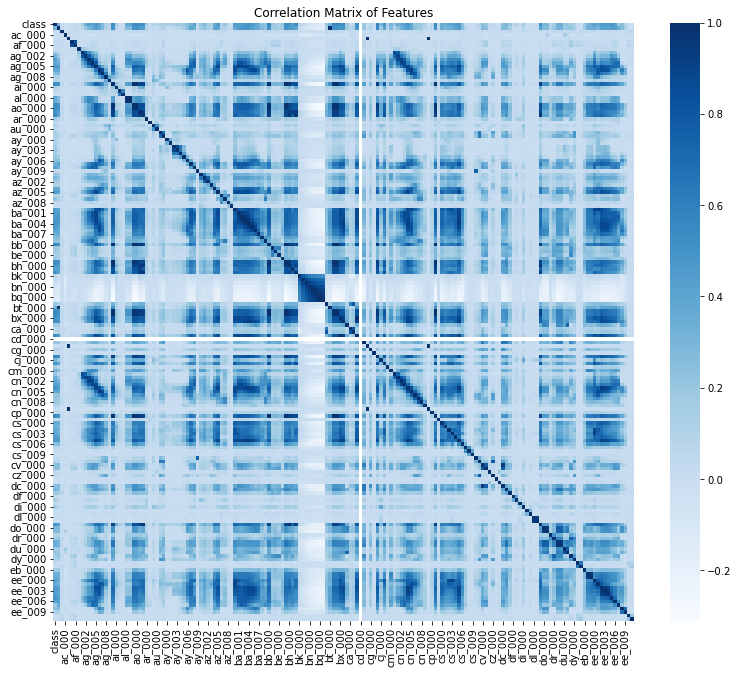

In [6]:
correlation_matrix = aps_df.corr()
plt.figure(figsize=(13, 11))
sns.heatmap(correlation_matrix, annot=False, cmap='Blues', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

#### iv. Pick √ 170 features with highest CV , and make scatter plots and box plots for them. Draw conclusions about significance of those features, just by the scatter plots? 

In [16]:
npa1 = aps_df.iloc[:,1:]
npa = npa1.values
cv =  lambda x: np.var(x) / np.mean(x)
var = np.apply_along_axis(cv, axis=0, arr=npa)
col= npa1.columns.values
colvar=pd.DataFrame(np.column_stack([col, var]))

sorte = colvar.sort_values(1, ascending=False)
highvar11= sorte.head(int(math.floor(math.sqrt(170))))
print(highvar11)

          0                  1
91   cf_000  6456040142.412879
109  co_000  6443759684.208034
3    ad_000   6438941302.24316
145  dq_000  1954734020.965007
2    ac_000  1674785264.520167
155  eb_000   204749449.253658
134  df_000    86747051.752844
136  dh_000     54611375.30477
140  dl_000    40506327.845407
122  cs_009    37981502.458716
149  du_000    32218416.108477
33   ay_001    27488734.212247
62   bb_000    26627168.858919


,cf_000,co_000,ad_000,dq_000,ac_000,eb_000,df_000,dh_000,dl_000,cs_009,du_000,ay_001,bb_000
37731,1238.000000,728.000000,2014.000000,0.0,2.298000e+03,8.725909e+07,2.418750e+06,0.000000,0.000000,0.0,102960.0,0.0,35065964.0
45112,190221.810984,190515.566938,190620.639314,0.0,0.000000e+00,3.866630e+07,0.000000e+00,0.000000,0.000000,0.0,2191620.0,0.0,2661576.0
56074,190221.810984,190515.566938,190620.639314,0.0,3.560143e+08,9.717093e+06,2.718638e+03,4707.073332,28541.774896,0.0,3868160.0,0.0,2373294.0
40928,190221.810984,190515.566938,190620.639314,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,154200.0,0.0,76730.0
4979,190221.810984,190515.566938,190620.639314,0.0,0.000000e+00,2.404230e+06,0.000000e+00,0.000000,0.000000,0.0,1948840.0,0.0,3653590.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57337,2.000000,0.000000,24.000000,13670.0,2.600000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,57140.0,0.0,81568.0
3315,2.000000,2.000000,2.000000,936.0,6.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,540.0,0.0,12722.0
8216,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.0,0.0,21184.0
49671,12.000000,4.000000,722.000000,0.0,2.130706e+09,4.021002e+07,0.000000e+00,0.000000,0.000000,6.0,9971840.0,0.0,2794842.0


/var/folders/23/9m01x4q95z39dw1k81mqd6n80000gn/T/ipykernel_83229/274158304.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


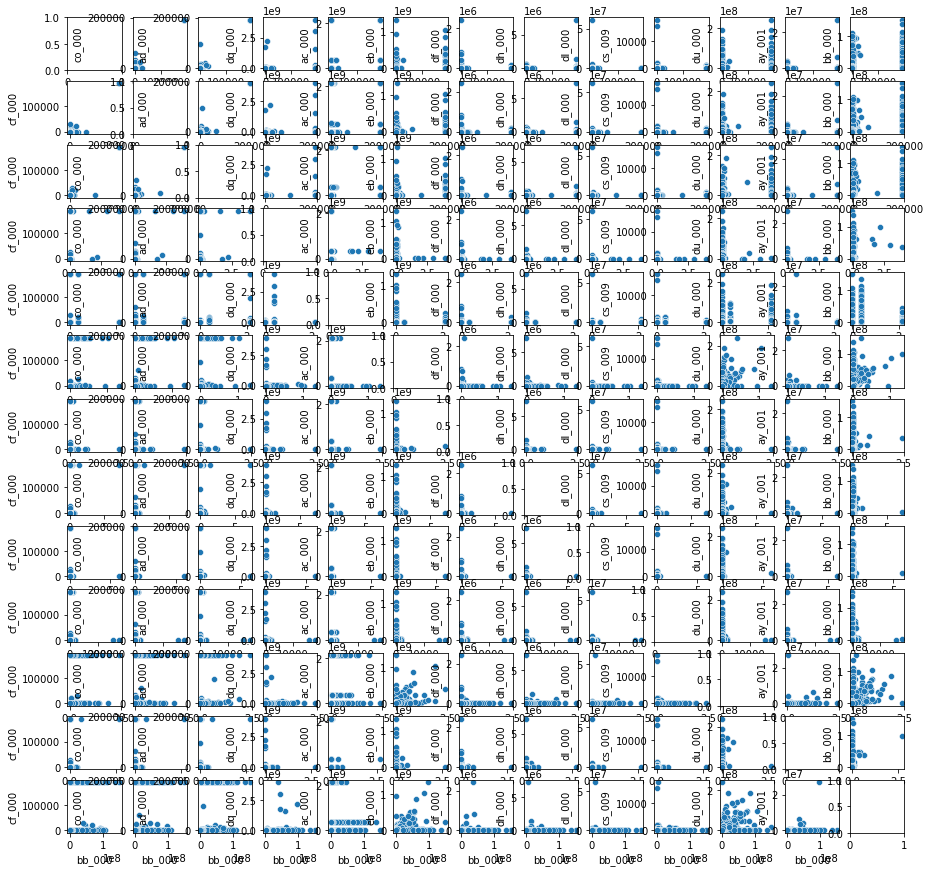

In [66]:
selected_column = aps_df[highvar11[0]]
selected_samples = selected_column.sample(n=5000, random_state=42)

feature_columns = selected_samples.columns

# Define the number of features
num_features = len(feature_columns)

# Create subplots
fig, axes = plt.subplots(nrows=num_features, ncols=num_features, figsize=(15, 15))

# Iterate through feature combinations
for i in range(num_features):
    for j in range(num_features):
        if i != j:
            # Scatter plot
            sns.scatterplot(x=selected_samples[feature_columns[i]], y=selected_samples[feature_columns[j]], ax=axes[i][j])
            axes[i][j].set_xlabel(feature_columns[i])
            axes[i][j].set_ylabel(feature_columns[j])

# Adjust the layout and spacing
plt.tight_layout()
plt.show()


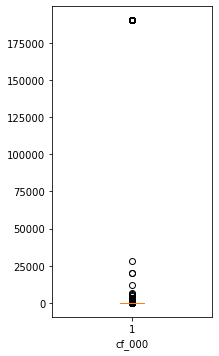

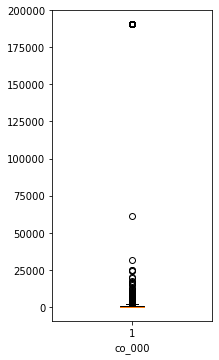

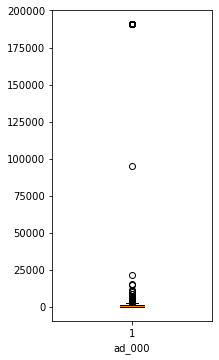

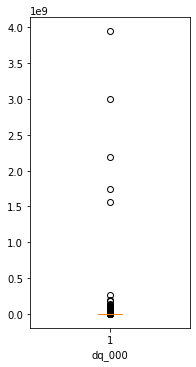

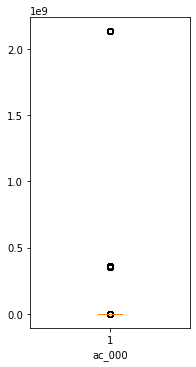

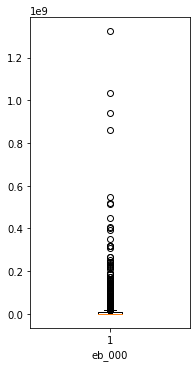

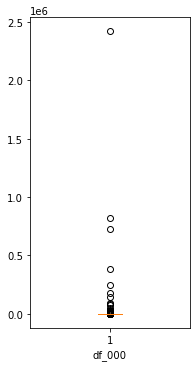

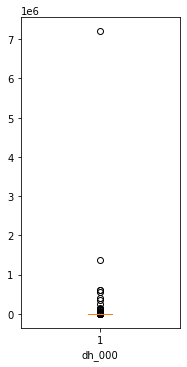

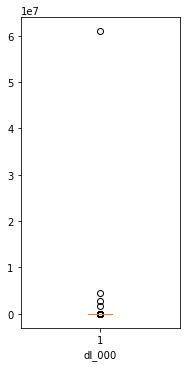

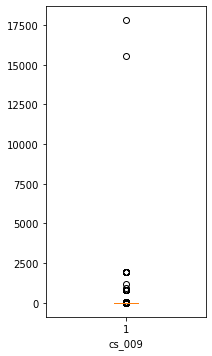

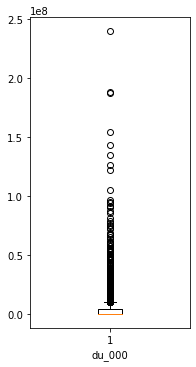

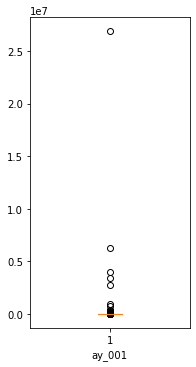

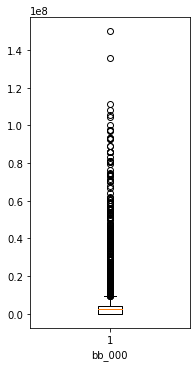

In [19]:
box = selected_samples.columns
i=1
for eachcol in box:
    plt.subplots(figsize=(20, 40))
    plt.subplot(6,6,i)
    plt.xlabel(eachcol)
    plt.boxplot(selected_samples[eachcol])
    i=i+1

#### v. Determine the number of positive and negative data. Is this data set imbalanced

In [21]:
neg_class_count = (aps_df['class'] == 0).sum()
pos_class_count = (aps_df['class'] == 1).sum()

class_count_df = pd.DataFrame({"count": [pos_class_count, neg_class_count]}, index=["positive", "negative"])
class_count_df

,count
positive,1375
negative,74625


Yes, this dataset is imbalanced. Since the positive class has significantly fewer samples compared to the negative class. The class distribution is highly skewed towards the "negative" class, indicating an imbalanced dataset.

### (c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them. Calculate Out of Bag error estimate for the random forset and compare it to the test error.

In [22]:
#split the data
x_train = aps_train.iloc[:,1:]
x_test = aps_test.iloc[:,1:]
y_train = aps_train.iloc[:,0:1]
y_test = aps_test.iloc[:,0:1]

In [23]:
#fit the model
rf = RandomForestClassifier(oob_score=True)
rf.fit(x_train, y_train.values.ravel())

RandomForestClassifier(oob_score=True)

In [24]:
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)

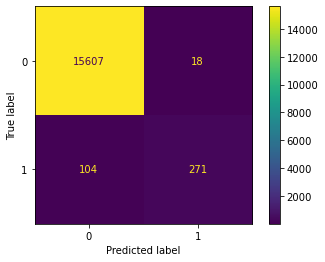

In [25]:
# confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_test).plot()

In [26]:
# Misclassification for Training Set
misclassification_train = 1 - accuracy_score(y_train, y_train_pred)

# Misclassification for Test Set
misclassification_test = 1 - accuracy_score(y_test, y_test_pred)

print("Misclassification for Training Set is", misclassification_train)
print("Misclassification for Test Set is", misclassification_test)

Misclassification for Training Set is 0.0
Misclassification for Test Set is 0.007624999999999993


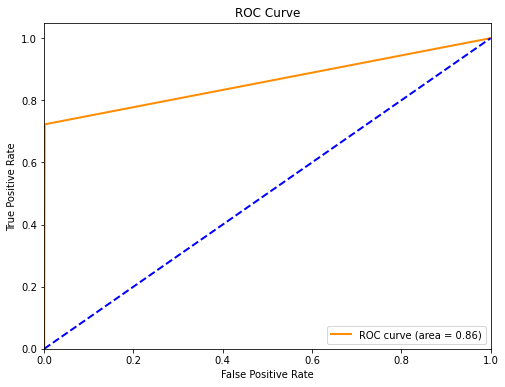

In [27]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_test_pred)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [28]:
#calculate the out of bag error and make comparison

oob_test_error = 1 - rf.oob_score_
print('oob test error:',oob_test_error)

test_error =1-rf.score(x_test, y_test)
print('test error:',test_error)

#comparison
if oob_test_error > test_error:
    print("Out of Bag error is larger than test error.")
else:
    print("Out of Bag error is smaller than test error.")

oob test error: 0.005966666666666676
test error: 0.007624999999999993
Out of Bag error is smaller than test error.


### (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in the random forest and repeat 1c. Compare the results with those of 1c

There are several techniques to address class imbalance in random forests:
Weighted Random Forests: Many random forest implementations allow you to assign different weights to classes. This means that errors in the minority class are penalized more heavily than errors in the majority class. This can be done by setting the class_weight parameter in scikit-learn's RandomForestClassifier to "balanced" or by providing custom class weights.
Resampling Techniques: Resampling methods involve modifying the training dataset to balance class distribution. There are two common approaches:
Oversampling the Minority Class: This involves creating additional copies of instances from the minority class until class balance is achieved. Techniques like Synthetic Minority Over-sampling Technique (SMOTE) are commonly used.
Undersampling the Majority Class: This approach reduces the number of instances from the majority class to match the minority class. Random undersampling and Tomek links are examples.

Compared to the model without compensating for class imbalance:
The change in class weights made the balanced model more capable of detecting the minority class, which may result in improved metrics related to the minority class. 
The test error increased, as the new model focus on improving the detection of the minority class. The model may become more sensitive to the positive class, leading to higher test erros.
The auc increased. This suggests that the balanced model is better at distinguishing between positive and negative classes.
In summary, the balanced model, which is more focused on detecting the minority class, may have a higher test error but can improve the AUC and minority class performance. The OOB error being smaller than the test error aligns with common expectations when using random forests.

In [29]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(x_train, y_train)

In [36]:
rf_blc = RandomForestClassifier(n_estimators=100, random_state=42,oob_score = True)
rf_blc.fit(X_train_resampled, y_train_resampled.values.ravel())

RandomForestClassifier(oob_score=True, random_state=42)

In [37]:
y_train_pred_2 = rf_blc.predict(x_train)
y_test_pred_2 = rf_blc.predict(x_test)

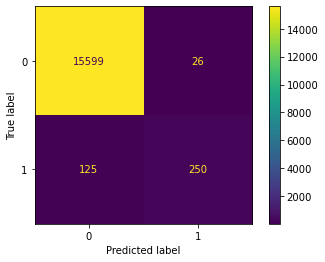

In [38]:
# confusion matrix
cm_test_2 = confusion_matrix(y_test, y_test_pred_2)
ConfusionMatrixDisplay(confusion_matrix=cm_test_2).plot()

In [39]:
# Misclassification for Training Set
misclassification_train_2 = 1 - accuracy_score(y_train, y_train_pred_2)

# Misclassification for Test Set
misclassification_test_2 = 1 - accuracy_score(y_test, y_test_pred_2)

print("Misclassification for Training Set is", misclassification_train_2)
print("Misclassification for Test Set is", misclassification_test_2)

Misclassification for Training Set is 0.0
Misclassification for Test Set is 0.009437499999999988


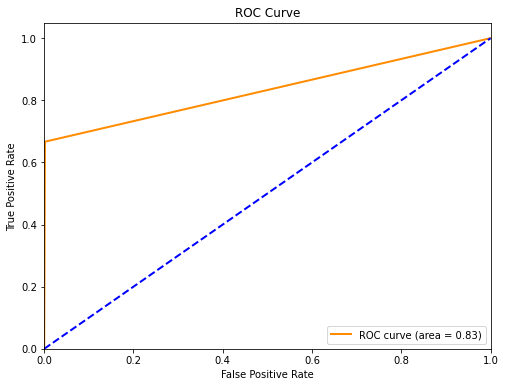

In [40]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_2)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_test_pred_2)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [41]:
#calculate the out of bag error and make comparison

oob_test_error_blc = 1 - rf_blc.oob_score_
print('oob test error:',oob_test_error_blc)

test_error_blc =1 - accuracy_score(y_test, y_test_pred_2)
print('test error:',test_error_blc)

#comparison
if oob_test_error_blc > test_error_blc:
    print("Out of Bag error is larger than test error.")
else:
    print("Out of Bag error is smaller than test error.")

oob test error: 0.0009152542372881101
test error: 0.009437499999999988
Out of Bag error is smaller than test error.


### (e) XGBoost and Model Trees

In [42]:
# Initialize the XGBoost classifier
xgb_model = XGBClassifier()

In [43]:
# Perform 5-fold cross-validation to estimate the error
alphas = [0.01, 0.1, 1, 10]  
best_alpha = None
best_auc = 0

for alpha in alphas:
    xgb_model = xgb.XGBClassifier(alpha=alpha, random_state=42)
    cv_aucs = cross_val_score(xgb_model, x_train, y_train, cv=5, scoring='roc_auc')
    mean_auc = cv_aucs.mean()
    
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_alpha = alpha
print("Best Alpha:", best_alpha)

Best Alpha: 10


In [44]:
final_model = xgb.XGBClassifier(alpha=best_alpha, random_state=42)
final_model.fit(x_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [45]:
y_train_pred_xgb = final_model.predict(x_train)
y_test_pred_xgb = final_model.predict(x_test)
y_test_pred_proba = final_model.predict_proba(x_test)[:, 1]

In [46]:
# Confusion Matrix
train_confusion_matrix = confusion_matrix(y_train, y_train_pred_xgb)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred_xgb)
print("Train Confusion Matrix:\n", train_confusion_matrix)
print("Test Confusion Matrix:\n", test_confusion_matrix)

Train Confusion Matrix:
 [[58986    14]
 [  113   887]]
Test Confusion Matrix:
 [[15607    18]
 [   91   284]]


In [47]:
# test error
train_error = 1-accuracy_score(y_train, y_train_pred_xgb)
test_error = 1-accuracy_score(y_test, y_test_pred_xgb)
print("Train Error:", train_error)
print("Test Error:", test_error)

cv_accuracyscore = cross_val_score(final_model, x_train, y_train, cv=5, scoring='accuracy')
# Calculate and report the mean AUC from cross-validation.
mean_error_cv = (1 - cv_accuracyscore).mean()
print("Mean error from 5-fold Cross-Validation:", mean_error_cv)

#compare test error and 5-fold cross validation error
if mean_error_cv>test_error:
    print("The error rate estimated by 5-fold Cross-Validation is larger than test error")
else:
    print("The error rate estimated by 5-fold Cross-Validation is smaller than test error")

Train Error: 0.0021166666666666556
Test Error: 0.006812499999999999
Mean error from 5-fold Cross-Validation: 0.006366666666666654
The error rate estimated by 5-fold Cross-Validation is smaller than test error


Train AUC: 0.9433813559322034
Test AUC: 0.9960214186666667


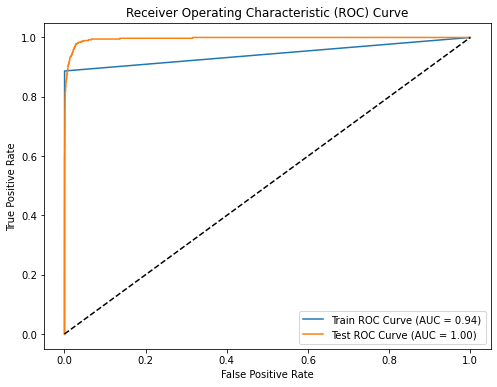

In [48]:
# ROC curve and AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_xgb)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
train_auc = roc_auc_score(y_train, y_train_pred_xgb)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print("Train AUC:", train_auc)
print("Test AUC:", test_auc)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label="Train ROC Curve (AUC = {:.2f})".format(train_auc))
plt.plot(fpr_test, tpr_test, label="Test ROC Curve (AUC = {:.2f})".format(test_auc))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


### (f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process the data to compensate for class imbalance. Train XGBosst with L 1 -penalized logistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

Compared to the uncompensated case, the SMOTE case has larger test error. The error rate estimated by 5-fold Cross-Validation is also larger than the uncompensated case. Also, the SMOTE focus on the positive cases more than the uncompensated case does.

In [49]:
# Use SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_f, y_resampled_f = smote.fit_resample(x_train, y_train)

In [50]:
# Train an XGBoost model with L1-penalized logistic regression
xgb_model_smote = XGBClassifier(
    objective="binary:logistic", 
    use_label_encoder=False,
    alpha=1,  # L1 regularization parameter
    random_state=42
)

In [51]:
xgb_model_smote.fit(X_resampled_f, y_resampled_f)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [53]:
y_train_pred_xgb2 = xgb_model_smote.predict(x_train)
y_test_pred_xgb2 = xgb_model_smote.predict(x_test)
y_test_pred_proba2 = xgb_model_smote.predict_proba(x_test)[:, 1]

In [54]:
# Confusion Matrix
train_confusion_matrix2 = confusion_matrix(y_train, y_train_pred_xgb2)
test_confusion_matrix2 = confusion_matrix(y_test, y_test_pred_xgb2)
print("Train Confusion Matrix:\n", train_confusion_matrix2)
print("Test Confusion Matrix:\n", test_confusion_matrix2)

Train Confusion Matrix:
 [[59000     0]
 [    1   999]]
Test Confusion Matrix:
 [[15349   276]
 [   46   329]]


In [55]:
# test error
train_error2 = 1-accuracy_score(y_train, y_train_pred_xgb2)
test_error2 = 1-accuracy_score(y_test, y_test_pred_xgb2)
print("Train Error:", train_error2)
print("Test Error:", test_error2)

cv_accuracyscore_2 = cross_val_score(xgb_model_smote, x_train, y_train, cv=5, scoring='accuracy')
# Calculate and report the mean AUC from cross-validation.
mean_error_cv_2 = (1 - cv_accuracyscore_2).mean()
print("Mean error from 5-fold Cross-Validation:", mean_error_cv_2)

#compare test error and 5-fold cross validation error
if mean_error_cv_2 > test_error2:
    print("The error rate estimated by 5-fold Cross-Validation is larger than test error")
else:
    print("The error rate estimated by 5-fold Cross-Validation is smaller than test error")

Train Error: 1.666666666666483e-05
Test Error: 0.02012499999999995
Mean error from 5-fold Cross-Validation: 0.005283333333333329
The error rate estimated by 5-fold Cross-Validation is smaller than test error


Train AUC: 0.9995
Test AUC: 0.9900057599999998


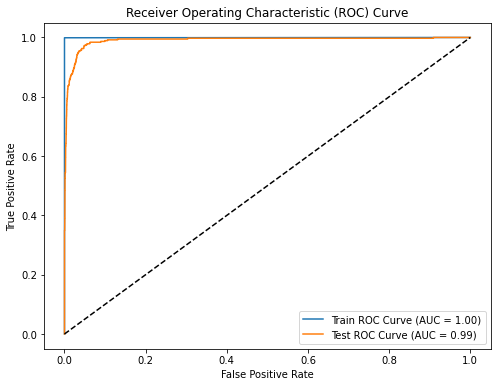

In [56]:
# ROC curve and AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_xgb2)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba2)
train_auc2 = roc_auc_score(y_train, y_train_pred_xgb2)
test_auc2 = roc_auc_score(y_test, y_test_pred_proba2)

print("Train AUC:", train_auc2)
print("Test AUC:", test_auc2)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label="Train ROC Curve (AUC = {:.2f})".format(train_auc2))
plt.plot(fpr_test, tpr_test, label="Test ROC Curve (AUC = {:.2f})".format(test_auc2))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()
